# Ecological index - Regional and hemispheric AEV distributions to find bin threshold values
- Plot historical reconstruction AEV Index spatial plots
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load data for eco index

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load the Present Day Ecoindex Data

In [7]:
file_in = 'ecoindex_present_day.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

In [8]:
# keep both hemispheric and regional versions
eco_pd_hemi = ds_eco.ecoindex_hemispheric
eco_pd = ds_eco.ecoindex_regional

# mask land
eco_pd_hemi = eco_pd_hemi.where(ds_grid.REGION_MASK == 1)
eco_pd = eco_pd.where(ds_grid.REGION_MASK == 1)

In [9]:
# mask where it's zero because that's out of SIZ
eco_pd_hemi = eco_pd_hemi.where(eco_pd_hemi > 0)
eco_pd = eco_pd.where(eco_pd > 0)

### Load regional masks

In [10]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [11]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


# Find AEV bins
- Use statistics on each region to get top % thresholds
- Plot the results to check that these look reasonable

In [12]:
# three thresholds: top 5%, 10% and 25%
f1 = 0.05
f2 = 0.1
f3 = 0.25

### Set plotting information

In [13]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [14]:
# get lat/lon info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [15]:
# set some plotting info
cmap_in = cmocean.cm.deep
vmin_in = 0.0
vmax_in = 1.0
# set contour levels
levels_in = np.arange(0,1.1,0.1)

In [16]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

### Load shapefiles

In [17]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [18]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Hemispheric

In [19]:
# set the data to get distribution of
data_in = eco_pd_hemi

In [20]:
# make array 1D
data_1d = data_in.stack(xdim=("nlat","nlon"))

# drop missing values
data_1d = data_1d.dropna(dim='xdim')

# sort the array from lowest to highest
data_1d_sort = data_1d.sortby(data_1d, ascending=True)

# print the number of values in this region
npts = data_1d_sort.shape[0]

# find index threshold values
ind_1 = npts - round(npts*f1)
ind_2 = npts - round(npts*f2)
ind_3 = npts - round(npts*f3)

# get cut off values for thresholds
value_max = np.round_(data_1d_sort[npts-1].values,decimals=2)
value_min = np.round_(data_1d_sort[0].values,decimals=2)
value_1 = np.round_(data_1d_sort[ind_1].values,decimals=2)
value_2 = np.round_(data_1d_sort[ind_2].values,decimals=2)
value_3 = np.round_(data_1d_sort[ind_3].values,decimals=2)

In [21]:
# assign this data to its own arrays
n_hemi = npts
hemi_1 = value_1
hemi_2 = value_2
hemi_3 = value_3
hemi_1d = data_1d_sort

Top 5% > 0.49
Top 10% > 0.38
Top 25% > 0.3


Text(0.5, 0.91, 'a) Hemispheric + bin thresholds')

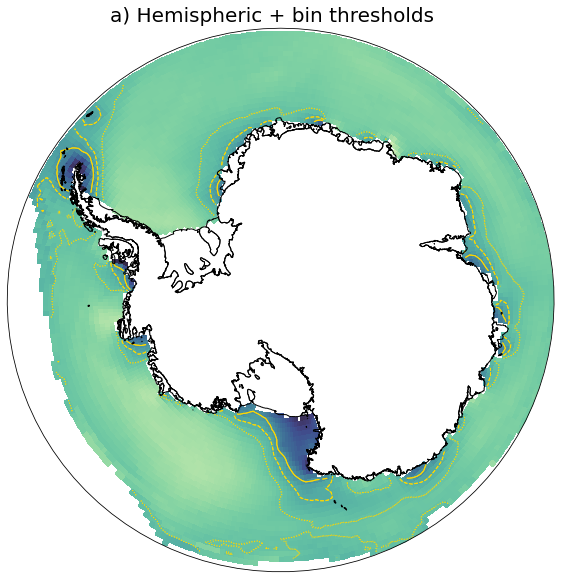

In [22]:
### Plot Present Day Hemispheric AEV Index
# get data to plot
data_plt = data_in
# set bin levels
print('Top 5% > '+str(hemi_1))
print('Top 10% > '+str(hemi_2))
print('Top 25% > '+str(hemi_3))
# set levels for three thresholds
levels_1 = np.arange(value_1,value_1+0.001,0.001)
levels_2 = np.arange(value_2,value_2+0.001,0.001)
levels_3 = np.arange(value_3,value_3+0.001,0.001)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())

### Overlay AEV top 5% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=1,
                 levels=levels_1,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 10% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dashed',linewidths=1,
                 levels=levels_2,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 25% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dotted',linewidths=1,
                 levels=levels_3,
                 transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add title
fig.suptitle('a) Hemispheric + bin thresholds',fontsize=20, y=0.91)  

### Weddell

In [23]:
# set the data to get distribution of
reg = 'mpa_plan_3_4'
data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)

In [24]:
# make array 1D
data_1d = data_in.stack(xdim=("nlat","nlon"))

# drop missing values
data_1d = data_1d.dropna(dim='xdim')

# sort the array from lowest to highest
data_1d_sort = data_1d.sortby(data_1d, ascending=True)

# print the number of values in this region
npts = data_1d_sort.shape[0]

# find index threshold values
ind_1 = npts - round(npts*f1)
ind_2 = npts - round(npts*f2)
ind_3 = npts - round(npts*f3)

# get cut off values for thresholds
value_max = np.round_(data_1d_sort[npts-1].values,decimals=2)
value_min = np.round_(data_1d_sort[0].values,decimals=2)
value_1 = np.round_(data_1d_sort[ind_1].values,decimals=2)
value_2 = np.round_(data_1d_sort[ind_2].values,decimals=2)
value_3 = np.round_(data_1d_sort[ind_3].values,decimals=2)

In [25]:
# assign this data to its own arrays
n_wedd = npts
wedd_1 = value_1
wedd_2 = value_2
wedd_3 = value_3
wedd_1d = data_1d_sort

Top 5% > 0.49
Top 10% > 0.38
Top 25% > 0.3


Text(0.5, 0.91, 'mpa_plan_3_4')

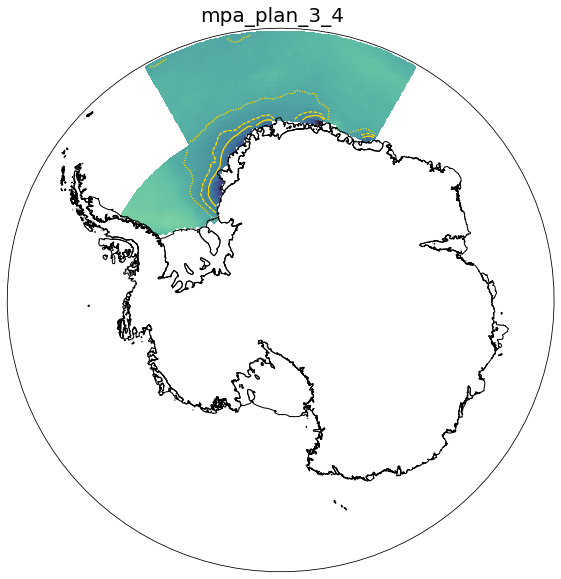

In [26]:
### Plot Present Day Regional AEV Index
# get data to plot
data_plt = data_in
# set bin levels
print('Top 5% > '+str(hemi_1))
print('Top 10% > '+str(hemi_2))
print('Top 25% > '+str(hemi_3))
# set levels for three thresholds
levels_1 = np.arange(value_1,value_1+0.001,0.001)
levels_2 = np.arange(value_2,value_2+0.001,0.001)
levels_3 = np.arange(value_3,value_3+0.001,0.001)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())

### Overlay AEV top 5% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=1,
                 levels=levels_1,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 10% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dashed',linewidths=1,
                 levels=levels_2,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 25% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dotted',linewidths=1,
                 levels=levels_3,
                 transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add title
fig.suptitle(reg,fontsize=20, y=0.91)  

### East Antarctica

In [27]:
# set the data to get distribution of
reg = 'mpa_plan_7_mod'

data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)

In [28]:
# make array 1D
data_1d = data_in.stack(xdim=("nlat","nlon"))

# drop missing values
data_1d = data_1d.dropna(dim='xdim')

# sort the array from lowest to highest
data_1d_sort = data_1d.sortby(data_1d, ascending=True)

# print the number of values in this region
npts = data_1d_sort.shape[0]

# find index threshold values
ind_1 = npts - round(npts*f1)
ind_2 = npts - round(npts*f2)
ind_3 = npts - round(npts*f3)

# get cut off values for thresholds
value_max = np.round_(data_1d_sort[npts-1].values,decimals=2)
value_min = np.round_(data_1d_sort[0].values,decimals=2)
value_1 = np.round_(data_1d_sort[ind_1].values,decimals=2)
value_2 = np.round_(data_1d_sort[ind_2].values,decimals=2)
value_3 = np.round_(data_1d_sort[ind_3].values,decimals=2)

In [29]:
# assign this data to its own arrays
n_eant = npts
eant_1 = value_1
eant_2 = value_2
eant_3 = value_3
eant_1d = data_1d_sort

Top 5% > 0.49
Top 10% > 0.38
Top 25% > 0.3


Text(0.5, 0.91, 'mpa_plan_7_mod')

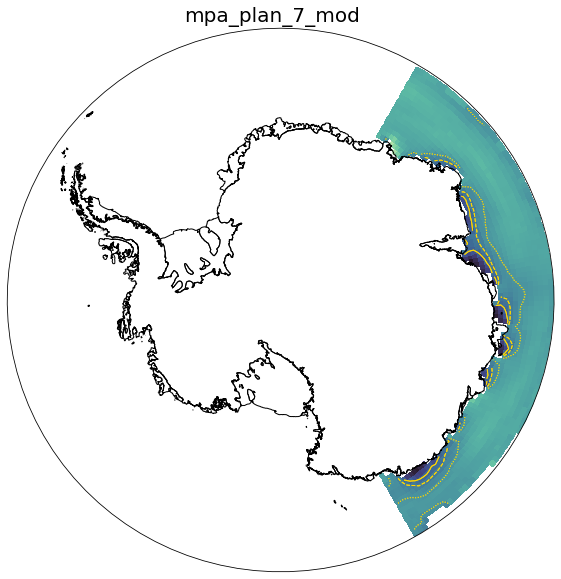

In [30]:
### Plot Present Day Regional AEV Index
# get data to plot
data_plt = data_in
# set bin levels
print('Top 5% > '+str(hemi_1))
print('Top 10% > '+str(hemi_2))
print('Top 25% > '+str(hemi_3))
# set levels for three thresholds
levels_1 = np.arange(value_1,value_1+0.001,0.001)
levels_2 = np.arange(value_2,value_2+0.001,0.001)
levels_3 = np.arange(value_3,value_3+0.001,0.001)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())

### Overlay AEV top 5% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=1,
                 levels=levels_1,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 10% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dashed',linewidths=1,
                 levels=levels_2,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 25% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dotted',linewidths=1,
                 levels=levels_3,
                 transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add title
fig.suptitle(reg,fontsize=20, y=0.91)  

### Ross Sea

In [31]:
# set the data to get distribution of
reg = 'mpa_plan_8'

data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)

In [32]:
# make array 1D
data_1d = data_in.stack(xdim=("nlat","nlon"))

# drop missing values
data_1d = data_1d.dropna(dim='xdim')

# sort the array from lowest to highest
data_1d_sort = data_1d.sortby(data_1d, ascending=True)

# print the number of values in this region
npts = data_1d_sort.shape[0]
print(npts)

# find index threshold values
ind_1 = npts - round(npts*f1)
ind_2 = npts - round(npts*f2)
ind_3 = npts - round(npts*f3)

# get cut off values for thresholds
value_max = np.round_(data_1d_sort[npts-1].values,decimals=2)
value_min = np.round_(data_1d_sort[0].values,decimals=2)
value_1 = np.round_(data_1d_sort[ind_1].values,decimals=2)
value_2 = np.round_(data_1d_sort[ind_2].values,decimals=2)
value_3 = np.round_(data_1d_sort[ind_3].values,decimals=2)

1386


In [33]:
# assign this data to its own arrays
n_ross = npts
ross_1 = value_1
ross_2 = value_2
ross_3 = value_3
ross_1d = data_1d_sort

Top 5% > 0.49
Top 10% > 0.38
Top 25% > 0.3


Text(0.5, 0.91, 'mpa_plan_8')

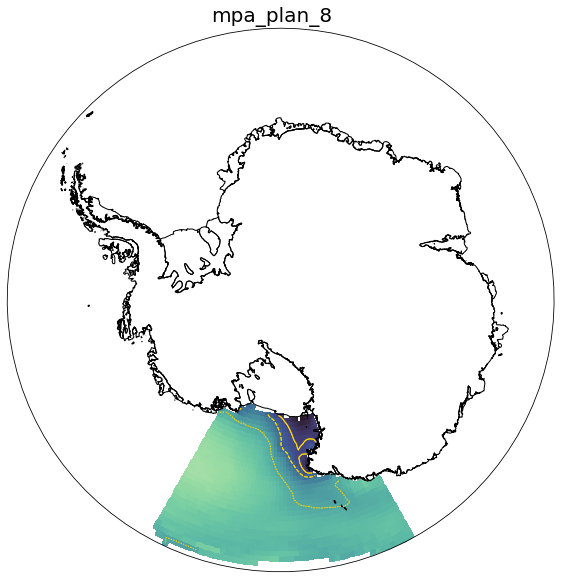

In [34]:
### Plot Present Day Regional AEV Index
# get data to plot
data_plt = data_in
# set bin levels
print('Top 5% > '+str(hemi_1))
print('Top 10% > '+str(hemi_2))
print('Top 25% > '+str(hemi_3))
# set levels for three thresholds
levels_1 = np.arange(value_1,value_1+0.001,0.001)
levels_2 = np.arange(value_2,value_2+0.001,0.001)
levels_3 = np.arange(value_3,value_3+0.001,0.001)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())

### Overlay AEV top 5% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=1,
                 levels=levels_1,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 10% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dashed',linewidths=1,
                 levels=levels_2,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 25% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dotted',linewidths=1,
                 levels=levels_3,
                 transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add title
fig.suptitle(reg,fontsize=20, y=0.91)  

### Amundsen Sea

In [35]:
# set the data to get distribution of
reg = 'mpa_plan_9'

data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)

In [36]:
# make array 1D
data_1d = data_in.stack(xdim=("nlat","nlon"))

# drop missing values
data_1d = data_1d.dropna(dim='xdim')

# sort the array from lowest to highest
data_1d_sort = data_1d.sortby(data_1d, ascending=True)

# print the number of values in this region
npts = data_1d_sort.shape[0]
print(npts)

# find index threshold values
ind_1 = npts - round(npts*f1)
ind_2 = npts - round(npts*f2)
ind_3 = npts - round(npts*f3)

# get cut off values for thresholds
value_max = np.round_(data_1d_sort[npts-1].values,decimals=2)
value_min = np.round_(data_1d_sort[0].values,decimals=2)
value_1 = np.round_(data_1d_sort[ind_1].values,decimals=2)
value_2 = np.round_(data_1d_sort[ind_2].values,decimals=2)
value_3 = np.round_(data_1d_sort[ind_3].values,decimals=2)

1068


In [37]:
# assign this data to its own arrays
n_amun = npts
amun_1 = value_1
amun_2 = value_2
amun_3 = value_3
amun_1d = data_1d_sort

Top 5% > 0.49
Top 10% > 0.38
Top 25% > 0.3


Text(0.5, 0.91, 'mpa_plan_9')

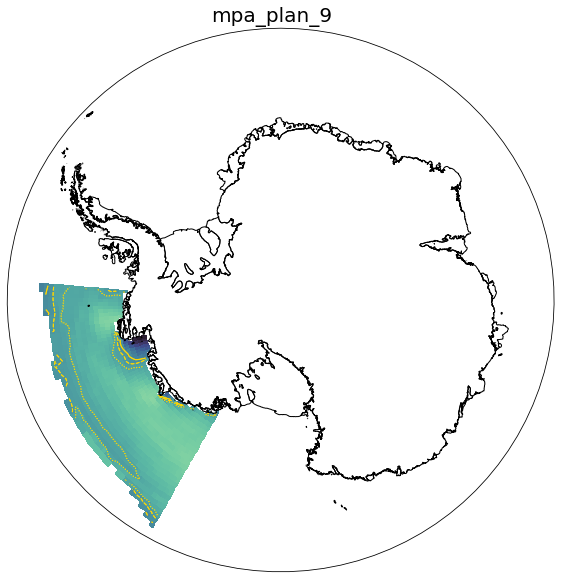

In [38]:
### Plot Present Day Regional AEV Index
# get data to plot
data_plt = data_in
# set bin levels
print('Top 5% > '+str(hemi_1))
print('Top 10% > '+str(hemi_2))
print('Top 25% > '+str(hemi_3))
# set levels for three thresholds
levels_1 = np.arange(value_1,value_1+0.001,0.001)
levels_2 = np.arange(value_2,value_2+0.001,0.001)
levels_3 = np.arange(value_3,value_3+0.001,0.001)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())

### Overlay AEV top 5% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=1,
                 levels=levels_1,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 10% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dashed',linewidths=1,
                 levels=levels_2,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 25% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dotted',linewidths=1,
                 levels=levels_3,
                 transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add title
fig.suptitle(reg,fontsize=20, y=0.91)  

### Antarctic Peninsula

In [39]:
# set the data to get distribution of
reg = 'mpa_plan_1_mod'

data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)

In [40]:
# make array 1D
data_1d = data_in.stack(xdim=("nlat","nlon"))

# drop missing values
data_1d = data_1d.dropna(dim='xdim')

# sort the array from lowest to highest
data_1d_sort = data_1d.sortby(data_1d, ascending=True)

# print the number of values in this region
npts = data_1d_sort.shape[0]
print(npts)

# find index threshold values
ind_1 = npts - round(npts*f1)
ind_2 = npts - round(npts*f2)
ind_3 = npts - round(npts*f3)

# get cut off values for thresholds
value_max = np.round_(data_1d_sort[npts-1].values,decimals=2)
value_min = np.round_(data_1d_sort[0].values,decimals=2)
value_1 = np.round_(data_1d_sort[ind_1].values,decimals=2)
value_2 = np.round_(data_1d_sort[ind_2].values,decimals=2)
value_3 = np.round_(data_1d_sort[ind_3].values,decimals=2)

791


In [41]:
# assign this data to its own arrays
n_apen = npts
apen_1 = value_1
apen_2 = value_2
apen_3 = value_3
apen_1d = data_1d_sort

Top 5% > 0.49
Top 10% > 0.38
Top 25% > 0.3


Text(0.5, 0.91, 'mpa_plan_1_mod')

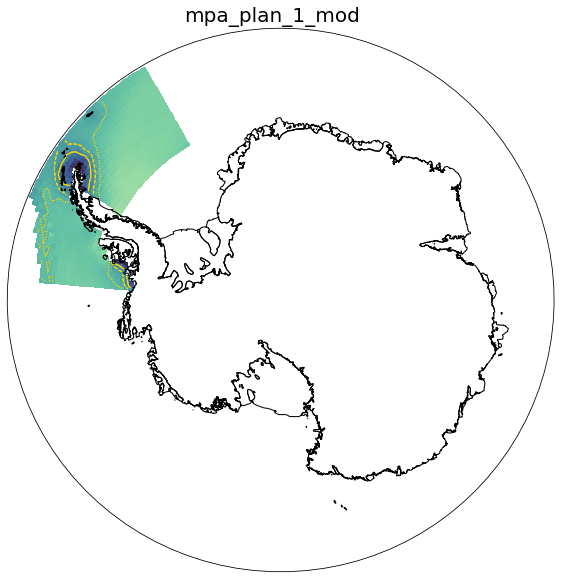

In [42]:
### Plot Present Day Regional AEV Index
# get data to plot
data_plt = data_in
# set bin levels
print('Top 5% > '+str(hemi_1))
print('Top 10% > '+str(hemi_2))
print('Top 25% > '+str(hemi_3))
# set levels for three thresholds
levels_1 = np.arange(value_1,value_1+0.001,0.001)
levels_2 = np.arange(value_2,value_2+0.001,0.001)
levels_3 = np.arange(value_3,value_3+0.001,0.001)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())

### Overlay AEV top 5% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=1,
                 levels=levels_1,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 10% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dashed',linewidths=1,
                 levels=levels_2,
                 transform=ccrs.PlateCarree())
### Overlay AEV top 25% line
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='dotted',linewidths=1,
                 levels=levels_3,
                 transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add title
fig.suptitle(reg,fontsize=20, y=0.91)  

## Histogram Distribution Plots

In [43]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'SFigure_AEV_distribution_present_day'

In [44]:
# set colors for thresholds
color1 = 'firebrick'
color2 = 'red'
color3 = 'salmon'

In [45]:
# set xaxis labels and tick marks
xarr = np.arange(0,1.1, 0.1)

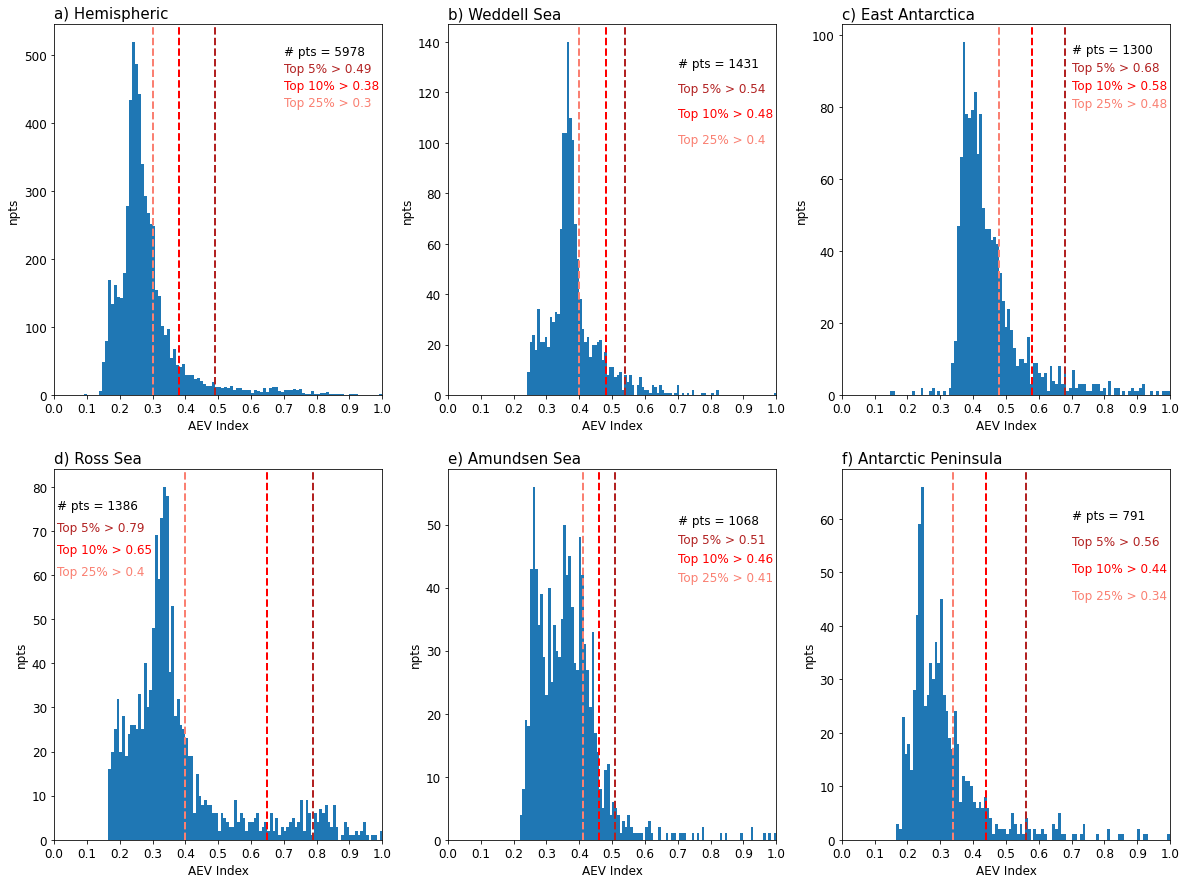

In [46]:
# Plot
# create figure
fig = plt.figure(figsize=(20,15))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Hemisphere ###
ax = fig.add_subplot(2,3,1)
ax.set_title('a) Hemispheric', loc='left',fontsize=15)
this=ax.hist(hemi_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index',fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts',fontsize=12)
plt.yticks(fontsize=12)
# add high and exceptional lines
plt.axvline(x=hemi_1, color=color1, linestyle='--',linewidth=2)
plt.axvline(x=hemi_2, color=color2, linestyle='--',linewidth=2)
plt.axvline(x=hemi_3, color=color3, linestyle='--',linewidth=2)
# add text about this lines
plt.text(0.7, 500, '# pts = '+str(n_hemi), fontsize=12)
plt.text(0.7, 475, 'Top 5% > '+str(hemi_1), color=color1, fontsize=12)
plt.text(0.7, 450, 'Top 10% > '+str(hemi_2), color=color2, fontsize=12)
plt.text(0.7, 425, 'Top 25% > '+str(hemi_3), color=color3, fontsize=12)

### Plot Weddell ###
ax = fig.add_subplot(2,3,2)
ax.set_title('b) Weddell Sea', loc='left',fontsize=15)
this=ax.hist(wedd_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index',fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts',fontsize=12)
plt.yticks(fontsize=12)
# add high and exceptional lines
plt.axvline(x=wedd_1, color=color1, linestyle='--',linewidth=2)
plt.axvline(x=wedd_2, color=color2, linestyle='--',linewidth=2)
plt.axvline(x=wedd_3, color=color3, linestyle='--',linewidth=2)
# add text about this lines
plt.text(0.7, 130, '# pts = '+str(n_wedd), fontsize=12)
plt.text(0.7, 120, 'Top 5% > '+str(wedd_1), color=color1, fontsize=12)
plt.text(0.7, 110, 'Top 10% > '+str(wedd_2), color=color2, fontsize=12)
plt.text(0.7, 100, 'Top 25% > '+str(wedd_3), color=color3, fontsize=12)

### Plot E.Ant ###
ax = fig.add_subplot(2,3,3)
ax.set_title('c) East Antarctica', loc='left',fontsize=15)
this=ax.hist(eant_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index',fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts',fontsize=12)
plt.yticks(fontsize=12)
# add high and exceptional lines
plt.axvline(x=eant_1, color=color1, linestyle='--',linewidth=2)
plt.axvline(x=eant_2, color=color2, linestyle='--',linewidth=2)
plt.axvline(x=eant_3, color=color3, linestyle='--',linewidth=2)
# add text about this lines
plt.text(0.7, 95, '# pts = '+str(n_eant), fontsize=12)
plt.text(0.7, 90, 'Top 5% > '+str(eant_1), color=color1, fontsize=12)
plt.text(0.7, 85, 'Top 10% > '+str(eant_2), color=color2, fontsize=12)
plt.text(0.7, 80, 'Top 25% > '+str(eant_3), color=color3, fontsize=12)

### Plot Ross Sea ###
ax = fig.add_subplot(2,3,4)
ax.set_title('d) Ross Sea', loc='left',fontsize=15)
this=ax.hist(ross_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index',fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts',fontsize=12)
plt.yticks(fontsize=12)
# add high and exceptional lines
plt.axvline(x=ross_1, color=color1, linestyle='--',linewidth=2)
plt.axvline(x=ross_2, color=color2, linestyle='--',linewidth=2)
plt.axvline(x=ross_3, color=color3, linestyle='--',linewidth=2)
# add text about this lines
plt.text(0.01, 75, '# pts = '+str(n_ross), fontsize=12)
plt.text(0.01, 70, 'Top 5% > '+str(ross_1), color=color1, fontsize=12)
plt.text(0.01, 65, 'Top 10% > '+str(ross_2), color=color2, fontsize=12)
plt.text(0.01, 60, 'Top 25% > '+str(ross_3), color=color3, fontsize=12)

### Plot Amundsen Sea ###
ax = fig.add_subplot(2,3,5)
ax.set_title('e) Amundsen Sea', loc='left',fontsize=15)
this=ax.hist(amun_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index',fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts',fontsize=12)
plt.yticks(fontsize=12)
# add high and exceptional lines
plt.axvline(x=amun_1, color=color1, linestyle='--',linewidth=2)
plt.axvline(x=amun_2, color=color2, linestyle='--',linewidth=2)
plt.axvline(x=amun_3, color=color3, linestyle='--',linewidth=2)
# add text about this lines
plt.text(0.7, 50, '# pts = '+str(n_amun), fontsize=12)
plt.text(0.7, 47, 'Top 5% > '+str(amun_1), color=color1, fontsize=12)
plt.text(0.7, 44, 'Top 10% > '+str(amun_2), color=color2, fontsize=12)
plt.text(0.7, 41, 'Top 25% > '+str(amun_3), color=color3, fontsize=12)

### Plot Peninsula ###
ax = fig.add_subplot(2,3,6)
ax.set_title('f) Antarctic Peninsula', loc='left',fontsize=15)
this=ax.hist(apen_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index',fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts',fontsize=12)
plt.yticks(fontsize=12)
# add high and exceptional lines
plt.axvline(x=apen_1, color=color1, linestyle='--',linewidth=2)
plt.axvline(x=apen_2, color=color2, linestyle='--',linewidth=2)
plt.axvline(x=apen_3, color=color3, linestyle='--',linewidth=2)
# add text about this lines
plt.text(0.7, 60, '# pts = '+str(n_apen), fontsize=12)
plt.text(0.7, 55, 'Top 5% > '+str(apen_1), color=color1, fontsize=12)
plt.text(0.7, 50, 'Top 10% > '+str(apen_2), color=color2, fontsize=12)
plt.text(0.7, 45, 'Top 25% > '+str(apen_3), color=color3, fontsize=12)


# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

## Make and save masks of these threshold values
- Save these as netcdf files for use in plots and statistics

In [47]:
# set information that will be part of bin coordinate array
bin_dim = ['5pct', '10pct','25pct']

### Hemisphere

In [48]:
# Hemispheric mask
data_in = eco_pd_hemi
thresh_1 = hemi_1
thresh_2 = hemi_2
thresh_3 = hemi_3

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make three masks for each threshold
reg_5 = reg_bins.where( (data_in.values >= thresh_1))
reg_10 = reg_bins.where( (data_in.values >= thresh_2) & (data_in.values < thresh_1))
reg_25 = reg_bins.where( (data_in.values >= thresh_3) & (data_in.values < thresh_2))

# concatentate into a single xarray and set dimensions
aev_bins_hemi = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_hemi['nlat'] = data_in.nlat
aev_bins_hemi['nlon'] = data_in.nlon
aev_bins_hemi['bin'] = bin_dim

### Regional

In [49]:
# Weddell mask
reg = 'mpa_plan_3_4'
data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)
thresh_1 = wedd_1
thresh_2 = wedd_2
thresh_3 = wedd_3

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make three masks for each threshold
reg_5 = reg_bins.where( (data_in.values >= thresh_1))
reg_10 = reg_bins.where( (data_in.values >= thresh_2) & (data_in.values < thresh_1))
reg_25 = reg_bins.where( (data_in.values >= thresh_3) & (data_in.values < thresh_2))

# concatentate into a single xarray and set dimensions
aev_bins_wedd = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_wedd['nlat'] = data_in.nlat
aev_bins_wedd['nlon'] = data_in.nlon
aev_bins_wedd['bin'] = bin_dim

In [50]:
# East Antarctica mask
reg = 'mpa_plan_7_mod'
data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)
thresh_1 = eant_1
thresh_2 = eant_2
thresh_3 = eant_3

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make three masks for each threshold
reg_5 = reg_bins.where( (data_in.values >= thresh_1))
reg_10 = reg_bins.where( (data_in.values >= thresh_2) & (data_in.values < thresh_1))
reg_25 = reg_bins.where( (data_in.values >= thresh_3) & (data_in.values < thresh_2))

# concatentate into a single xarray and set dimensions
aev_bins_eant = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_eant['nlat'] = data_in.nlat
aev_bins_eant['nlon'] = data_in.nlon
aev_bins_eant['bin'] = bin_dim

In [51]:
# Ross mask
reg = 'mpa_plan_8'
data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)
thresh_1 = ross_1
thresh_2 = ross_2
thresh_3 = ross_3

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make three masks for each threshold
reg_5 = reg_bins.where( (data_in.values >= thresh_1))
reg_10 = reg_bins.where( (data_in.values >= thresh_2) & (data_in.values < thresh_1))
reg_25 = reg_bins.where( (data_in.values >= thresh_3) & (data_in.values < thresh_2))

# concatentate into a single xarray and set dimensions
aev_bins_ross = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_ross['nlat'] = data_in.nlat
aev_bins_ross['nlon'] = data_in.nlon
aev_bins_ross['bin'] = bin_dim

In [52]:
# Amundsen mask
reg = 'mpa_plan_9'
data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)
thresh_1 = amun_1
thresh_2 = amun_2
thresh_3 = amun_3

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make three masks for each threshold
reg_5 = reg_bins.where( (data_in.values >= thresh_1))
reg_10 = reg_bins.where( (data_in.values >= thresh_2) & (data_in.values < thresh_1))
reg_25 = reg_bins.where( (data_in.values >= thresh_3) & (data_in.values < thresh_2))

# concatentate into a single xarray and set dimensions
aev_bins_amun = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_amun['nlat'] = data_in.nlat
aev_bins_amun['nlon'] = data_in.nlon
aev_bins_amun['bin'] = bin_dim

In [53]:
# Amundsen mask
reg = 'mpa_plan_1_mod'
data_in = eco_pd.where(ccamlr_masks.sel(region=reg) ==1)
thresh_1 = apen_1
thresh_2 = apen_2
thresh_3 = apen_3

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make three masks for each threshold
reg_5 = reg_bins.where( (data_in.values >= thresh_1))
reg_10 = reg_bins.where( (data_in.values >= thresh_2) & (data_in.values < thresh_1))
reg_25 = reg_bins.where( (data_in.values >= thresh_3) & (data_in.values < thresh_2))

# concatentate into a single xarray and set dimensions
aev_bins_apen = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_apen['nlat'] = data_in.nlat
aev_bins_apen['nlon'] = data_in.nlon
aev_bins_apen['bin'] = bin_dim

In [54]:
# Combine the regional data into a single array with the three levels

# make arrays
reg_bins = np.ones([len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('nlat','nlon'))

# make 5% mask
tmp1 = aev_bins_wedd.isel(bin=0).fillna(0)
tmp2 = aev_bins_eant.isel(bin=0).fillna(0)
tmp3 = aev_bins_ross.isel(bin=0).fillna(0)
tmp4 = aev_bins_amun.isel(bin=0).fillna(0)
tmp5 = aev_bins_apen.isel(bin=0).fillna(0)
tmp = tmp1+tmp2+tmp3+tmp4+tmp5
reg_5 = tmp.where(tmp == 1)
# make 10% mask
tmp1 = aev_bins_wedd.isel(bin=1).fillna(0)
tmp2 = aev_bins_eant.isel(bin=1).fillna(0)
tmp3 = aev_bins_ross.isel(bin=1).fillna(0)
tmp4 = aev_bins_amun.isel(bin=1).fillna(0)
tmp5 = aev_bins_apen.isel(bin=1).fillna(0)
tmp = tmp1+tmp2+tmp3+tmp4+tmp5
reg_10 = tmp.where(tmp == 1)
# make 25% mask
tmp1 = aev_bins_wedd.isel(bin=2).fillna(0)
tmp2 = aev_bins_eant.isel(bin=2).fillna(0)
tmp3 = aev_bins_ross.isel(bin=2).fillna(0)
tmp4 = aev_bins_amun.isel(bin=2).fillna(0)
tmp5 = aev_bins_apen.isel(bin=2).fillna(0)
tmp = tmp1+tmp2+tmp3+tmp4+tmp5
reg_25 = tmp.where(tmp == 1)

# concatentate into a single xarray and set dimensions
aev_bins_region = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_region['nlat'] = data_in.nlat
aev_bins_region['nlon'] = data_in.nlon
aev_bins_region['bin'] = bin_dim

### Save these data into a single file

In [55]:
ds_out = xr.Dataset()

ds_out['aev_bins_hemi'] = aev_bins_hemi
ds_out['aev_bins_region'] = aev_bins_region
ds_out['aev_bins_wedd'] = aev_bins_wedd
ds_out['aev_bins_eant'] = aev_bins_eant
ds_out['aev_bins_ross'] = aev_bins_ross
ds_out['aev_bins_amun'] = aev_bins_amun
ds_out['aev_bins_apen'] = aev_bins_apen
ds_out['REGION_MASK'] = ds_grid.REGION_MASK

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Ecological Index Bins for - present day historical reconstruction. For each region the exceptional, very high, and high bins based on PDF.'
ds_out.attrs['units'] = f'Unitless'

ds_out

<xarray.Dataset>
Dimensions:          (nlat: 36, nlon: 320, bin: 3)
Coordinates:
  * nlat             (nlat) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * nlon             (nlon) int64 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
  * bin              (bin) <U5 '5pct' '10pct' '25pct'
    region           <U14 'mpa_plan_1_mod'
    ULONG            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT             (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    aev_bins_hemi    (bin, nlat, nlon) float64 nan nan nan nan ... 1.0 1.0 1.0
    aev_bins_region  (bin, nlat, nlon) float64 nan nan nan nan ... 1.0 1.0 nan
    aev_bins_wedd    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_eant    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_ross    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_amun    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_apen    (bin, nlat, nlon) float64 nan nan nan nan ... 1.0 1.0 nan
    REGION_MASK      (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-04
    contents:        Ecological Index Bins for - present day historical recon...
    units:           Unitless

In [56]:
# drop unnecessary coordinates
ds_out = ds_out.drop('region')
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [57]:
ds_out

<xarray.Dataset>
Dimensions:          (nlat: 36, nlon: 320, bin: 3)
Coordinates:
  * nlat             (nlat) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * nlon             (nlon) int64 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
  * bin              (bin) <U5 '5pct' '10pct' '25pct'
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    aev_bins_hemi    (bin, nlat, nlon) float64 nan nan nan nan ... 1.0 1.0 1.0
    aev_bins_region  (bin, nlat, nlon) float64 nan nan nan nan ... 1.0 1.0 nan
    aev_bins_wedd    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_eant    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_ross    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_amun    (bin, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    aev_bins_apen    (bin, nlat, nlon) float64 nan nan nan nan ... 1.0 1.0 nan
    REGION_MASK      (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-04
    contents:        Ecological Index Bins for - present day historical recon...
    units:           Unitless

In [58]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
	bin: (3,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 

In [59]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.00 GB.


In [60]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'
file_out = 'ecoindex_present_day_bins.nc'
fout = path_out + file_out

In [61]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)